## Установка библиотек

In [2]:
!pip install -U imbalanced-learn
!pip install -U keras-tuner
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install tensorflow

  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
  Using cached numpy-1.24.2-cp311-cp311-win_amd64.whl (14.8 MB)
  Using cached scipy-1.10.1-cp311-cp311-win_amd64.whl (42.2 MB)
  Using cached scikit_learn-1.2.2-cp311-cp311-win_amd64.whl (8.3 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached keras_tuner-1.3.0-py3-none-any.whl (167 kB)
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached kt_legacy-1.0.4-py3-none-any.whl (9.6 kB)
     ---------------------------------------- 0.0/272.9 MB ? eta -:--:--
     ---------------------------------------- 0.1/272.9 MB 1.1 MB/s eta 0:04:11
     ---------------------------------------- 0.2/272.9 MB 1.5 MB/s eta 0:02:59
     ---------------------------------------- 0.4/272.9 MB 2.5 MB/s eta 0:01:48
     ---------------------------------------- 0.6/272.9 MB 3.3 MB/s eta 0:01:23
     ---------------------------------------- 0.9/272.9 MB 

In [15]:
!pip install tabpfn


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install keras-self-attention

  Using cached keras-self-attention-0.51.0.tar.gz (11 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18915 sha256=76e0e5fd628e78fb37eff85de34505e4625d3152e145ff5490e11d9be46aeb86
  Stored in directory: c:\users\dddl\appdata\local\pip\cache\wheels\0e\d5\84\78c085760ee12f6c1b7be1c1e81f87f8d07287ba1773d7e4ee
Successfully built keras-self-attention



[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Импорт модулей

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from datret.datret import DatRetClassifier
from tabpfn import TabPFNClassifier
from keras_self_attention import SeqSelfAttention

import tensorflow as tf
from tensorflow import keras
# from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict, cross_val_score

## Работа с файлами данных

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
tf.test.is_gpu_available()

False

### Чтение

In [2]:
data1 = pd.read_csv('Normal_data.csv')
data2 = pd.read_csv('OVS.csv')
data3 = pd.read_csv('metasploitable-2.csv')

data = pd.concat([data1, data2, data3], axis=0)

Сконцентрируемся на задаче обнаружения вторжений для SDN, поэтому оставим только те признаки, которые можно получать с SDN-контроллера

In [3]:
data.drop(['Flow ID', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Timestamp'], axis=1, inplace=True)

data.Label.replace(['DDoS '], 'DDoS', inplace=True)

### Препроцессинг

In [4]:
# Выделение целевой переменной
target_col = data['Label']
data.drop(['Label'], axis=1, inplace=True)

# Нормализация
data = (data-data.min()) / (data.max()-data.min())

target_col.replace('Normal', 0, inplace=True)
target_col.replace('BFA', 1, inplace=True)
target_col.replace('DDoS', 2, inplace=True)
target_col.replace('DoS', 3, inplace=True)
target_col.replace('Probe', 4, inplace=True)
target_col.replace('Web-Attack', 5, inplace=True)
target_col.replace('BOTNET', 6, inplace=True)
target_col.replace('U2R', 7, inplace=True)
data = data.astype('float32')
target_col = target_col.astype('int32')

# Разделение на выборки
X_train, X_rem, y_train, y_rem = train_test_split(data, target_col, train_size=0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

# print('y_train value counts:')
# print(y_train.value_counts())
# print('y_test value counts:')
# print(y_test.value_counts())
# print('target value counts:')
# print(target_col.value_counts())

In [5]:
# Функция вывода матрицы ошибок
def plot_confusion_matrix(cm):
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(5, 5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['Normal', 'BFA', 'DDoS', 'DoS', 'Probe', 'Web-Attack', 'BOTNET', 'U2R'], 
                yticklabels=['Normal', 'BFA', 'DDoS', 'DoS', 'Probe', 'Web-Attack', 'BOTNET', 'U2R'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

In [6]:
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
print(y_sm.value_counts())

# X_sm.to_csv('/content/drive/MyDrive/КНИР/data/X_train.csv')
# y_sm.to_csv('/content/drive/MyDrive/КНИР/data/y_train.csv')

# X_test.to_csv('/content/drive/MyDrive/КНИР/data/X_test.csv')
# y_test.to_csv('/content/drive/MyDrive/КНИР/data/y_test.csv')

# X_valid.to_csv('/content/drive/MyDrive/КНИР/data/X_valid.csv')
# y_valid.to_csv('/content/drive/MyDrive/КНИР/data/y_valid.csv')

2    97529
0    97529
4    97529
3    97529
1    97529
5    97529
6    97529
7    97529
Name: Label, dtype: int64


## Анализ данных

### Decision Tree

In [ ]:
max_depth = [int(x) for x in np.linspace(10, 50, 5)]
max_depth.append(None)
tree_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [int(x) for x in np.linspace(2, 50, 5)],
    'max_depth': max_depth,
    'random_state': [42]
}

tree_base = DecisionTreeClassifier()
tree_gr = GridSearchCV(estimator=tree_base, param_grid=tree_grid, cv=2, verbose=1)
tree_gr.fit(X_sm, y_sm)
tree_gr.best_params_

Fitting 2 folds for each of 90 candidates, totalling 180 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message, FitFaile

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_split': 2,
 'random_state': 42}

In [8]:
tree = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=20, min_samples_split=2)
tree.fit(X_sm, y_sm)

DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)

Accuracy:  0.9848788856901917
F1:  0.838525819625586


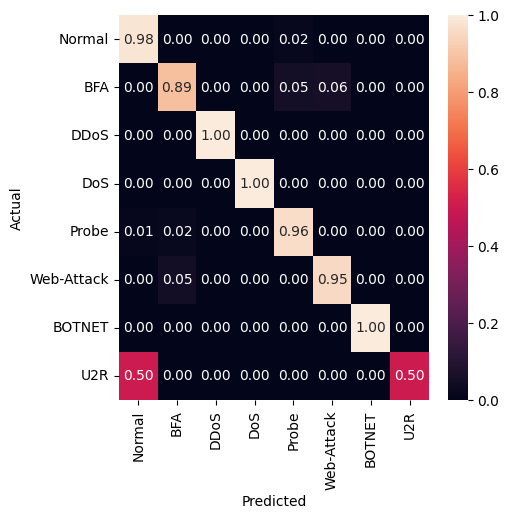

In [9]:
y_pred = tree.predict(X_test)
tree_acc = accuracy_score(y_test,y_pred)
tree_f1 = f1_score(y_test,y_pred, average='macro')
print('Accuracy: ', tree_acc)
print('F1: ', tree_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

### Random Forest

In [ ]:
max_depth = [int(x) for x in np.linspace(10, 50, 5)]
max_depth.append(None)
rf_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [100, 200, 300],
    'max_depth': max_depth,
    'max_features': ['sqrt', 'log2'],
    'random_state': [42]
}

rf_base = RandomForestClassifier()
rf_gr = GridSearchCV(estimator = rf_base, param_grid = rf_grid, cv = 2, verbose = 2)
rf_gr.fit(X_sm, y_sm)
rf_gr.best_params_

Fitting 2 folds for each of 108 candidates, totalling 216 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, random_state=42; total time= 1.4min
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, random_state=42; total time= 1.5min
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200, random_state=42; total time= 2.9min
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200, random_state=42; total time= 2.8min
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=300, random_state=42; total time= 4.3min
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=300, random_state=42; total time= 4.2min
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100, random_state=42; total time= 1.2min
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100, random_state=42; total time= 1.2min
[CV] END criterion=gini, max_depth=10, ma

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
72 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", 

{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'n_estimators': 300,
 'random_state': 42}

Accuracy:  0.9853732298118585
F1:  0.855088198304107


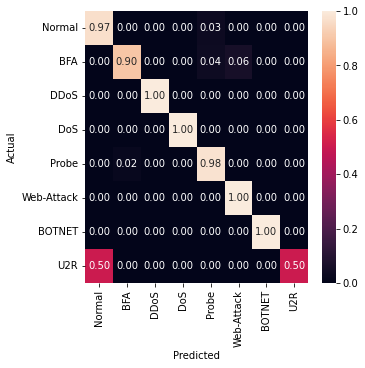

In [ ]:
# rf = RandomForestClassifier(random_state=42, criterion='gini', max_depth=50, max_features='sqrt', n_estimators=300)
# rf = RandomForestClassifier(random_state=42, criterion='gini', max_depth=50, max_features='sqrt', n_estimators=500)
rf.fit(X_sm, y_sm)

y_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test,y_pred)
rf_f1 = f1_score(y_test,y_pred, average='macro')
print('Accuracy: ', rf_acc)
print('F1: ', rf_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

### k-NN

In [ ]:
knn_grid = {
    'n_neighbors': [int(x) for x in np.linspace(2, 7, 1)],
    #'weights': ['uniform', 'distance'],
    'leaf_size': [20, 30, 50],
    'metric': ['cosine', 'euclidean']
}

knn_base = KNeighborsClassifier()
knn_gr = GridSearchCV(estimator = knn_base, param_grid = knn_grid, cv = 2, verbose = 2)
knn_gr.fit(X_sm, y_sm)
knn_gr.best_params_

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END .........leaf_size=20, metric=cosine, n_neighbors=2; total time=36.3min
[CV] END .........leaf_size=20, metric=cosine, n_neighbors=2; total time=35.7min
[CV] END ......leaf_size=20, metric=euclidean, n_neighbors=2; total time=60.5min
[CV] END ......leaf_size=20, metric=euclidean, n_neighbors=2; total time=59.6min
[CV] END .........leaf_size=30, metric=cosine, n_neighbors=2; total time=35.1min
[CV] END .........leaf_size=30, metric=cosine, n_neighbors=2; total time=35.2min
[CV] END ......leaf_size=30, metric=euclidean, n_neighbors=2; total time=59.3min
[CV] END ......leaf_size=30, metric=euclidean, n_neighbors=2; total time=61.1min
[CV] END .........leaf_size=50, metric=cosine, n_neighbors=2; total time=35.8min
[CV] END .........leaf_size=50, metric=cosine, n_neighbors=2; total time=35.6min
[CV] END ......leaf_size=50, metric=euclidean, n_neighbors=2; total time=59.3min
[CV] END ......leaf_size=50, metric=euclidean, n_

{'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 2}

Accuracy:  0.9826979557416616
F1:  0.8304968707278311


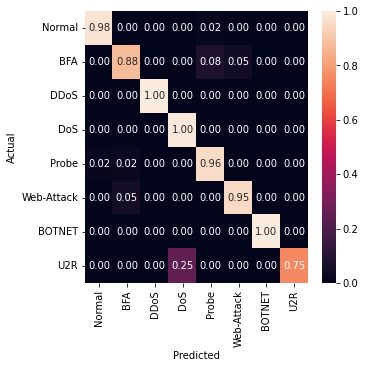

In [ ]:
# knn = KNeighborsClassifier(leaf_size=20, metric='euclidean', n_neighbors=4)
# knn = KNeighborsClassifier(leaf_size=40, metric='euclidean', n_neighbors=4)
knn = KNeighborsClassifier(leaf_size=40, metric='euclidean', n_neighbors=4)
knn.fit(X_sm, y_sm)

y_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test,y_pred)
knn_f1 = f1_score(y_test,y_pred, average='macro')
print('Accuracy: ', knn_acc)
print('F1: ', knn_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

### Logistic Regression

In [ ]:
lr_grid = {
    'C': [1., 1e2, 1e4, 1e5],
    'max_iter': [100, 200, 300],
    'multi_class': ['ovr', 'multinomial']
}

lr_base = LogisticRegression()
lr_gr = GridSearchCV(estimator = lr_base, param_grid = lr_grid, cv = 2, verbose = 1)
lr_gr.fit(X_sm, y_sm)
lr_gr.best_params_

Fitting 2 folds for each of 24 candidates, totalling 48 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ...............C=1.0, max_iter=100, multi_class=ovr; total time=  48.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ...............C=1.0, max_iter=100, multi_class=ovr; total time=  46.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......C=1.0, max_iter=100, multi_class=multinomial; total time=  34.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......C=1.0, max_iter=100, multi_class=multinomial; total time=  32.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............C=1.0, max_iter=200, multi_class=ovr; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ...............C=1.0, max_iter=200, multi_class=ovr; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......C=1.0, max_iter=200, multi_class=multinomial; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......C=1.0, max_iter=200, multi_class=multinomial; total time= 1.1min
[CV] END ...............C=1.0, max_iter=300, multi_class=ovr; total time= 1.2min
[CV] END ...............C=1.0, max_iter=300, multi_class=ovr; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......C=1.0, max_iter=300, multi_class=multinomial; total time= 1.8min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......C=1.0, max_iter=300, multi_class=multinomial; total time= 1.7min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END .............C=100.0, max_iter=100, multi_class=ovr; total time=  52.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END .............C=100.0, max_iter=100, multi_class=ovr; total time=  49.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=100.0, max_iter=100, multi_class=multinomial; total time=  31.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=100.0, max_iter=100, multi_class=multinomial; total time=  32.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END .............C=100.0, max_iter=200, multi_class=ovr; total time= 1.6min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END .............C=100.0, max_iter=200, multi_class=ovr; total time= 1.7min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=100.0, max_iter=200, multi_class=multinomial; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=100.0, max_iter=200, multi_class=multinomial; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END .............C=100.0, max_iter=300, multi_class=ovr; total time= 2.4min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END .............C=100.0, max_iter=300, multi_class=ovr; total time= 2.4min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=100.0, max_iter=300, multi_class=multinomial; total time= 1.6min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=100.0, max_iter=300, multi_class=multinomial; total time= 1.6min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ...........C=10000.0, max_iter=100, multi_class=ovr; total time=  51.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ...........C=10000.0, max_iter=100, multi_class=ovr; total time=  54.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...C=10000.0, max_iter=100, multi_class=multinomial; total time=  31.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...C=10000.0, max_iter=100, multi_class=multinomial; total time=  33.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ...........C=10000.0, max_iter=200, multi_class=ovr; total time= 1.8min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ...........C=10000.0, max_iter=200, multi_class=ovr; total time= 1.8min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...C=10000.0, max_iter=200, multi_class=multinomial; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...C=10000.0, max_iter=200, multi_class=multinomial; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ...........C=10000.0, max_iter=300, multi_class=ovr; total time= 2.7min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ...........C=10000.0, max_iter=300, multi_class=ovr; total time= 2.7min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...C=10000.0, max_iter=300, multi_class=multinomial; total time= 1.6min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...C=10000.0, max_iter=300, multi_class=multinomial; total time= 1.6min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ..........C=100000.0, max_iter=100, multi_class=ovr; total time=  51.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ..........C=100000.0, max_iter=100, multi_class=ovr; total time=  50.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..C=100000.0, max_iter=100, multi_class=multinomial; total time=  33.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..C=100000.0, max_iter=100, multi_class=multinomial; total time=  31.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ..........C=100000.0, max_iter=200, multi_class=ovr; total time= 1.7min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ..........C=100000.0, max_iter=200, multi_class=ovr; total time= 1.8min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..C=100000.0, max_iter=200, multi_class=multinomial; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..C=100000.0, max_iter=200, multi_class=multinomial; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ..........C=100000.0, max_iter=300, multi_class=ovr; total time= 2.8min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV] END ..........C=100000.0, max_iter=300, multi_class=ovr; total time= 2.9min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..C=100000.0, max_iter=300, multi_class=multinomial; total time= 1.7min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..C=100000.0, max_iter=300, multi_class=multinomial; total time= 1.8min


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

{'C': 100000.0, 'max_iter': 300, 'multi_class': 'ovr'}

In [ ]:
# 1 - {'C': 100000.0, 'max_iter': 300, 'multi_class': 'ovr'}
# 2 - {'C': 100000.0, 'max_iter': 500, 'multi_class': 'ovr'}
# 3 - {'C': 100000.0, 'max_iter': 1000, 'multi_class': 'ovr'}
# 4 - {'C': 100000.0, 'max_iter': 10000, 'multi_class': 'ovr'}
lr = LogisticRegression(max_iter=10000, C=100000., multi_class='ovr')
lr.fit(X_sm, y_sm)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LogisticRegression(C=100000.0, max_iter=10000, multi_class='ovr')

Accuracy:  0.908633574689581
F1:  0.5595207644992766


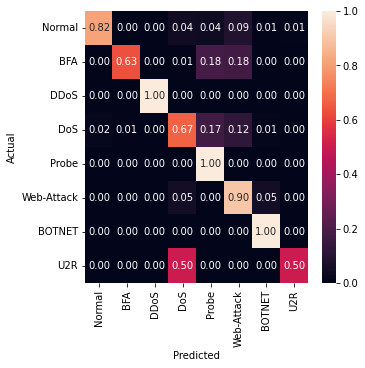

In [ ]:
y_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test,y_pred)
lr_f1 = f1_score(y_test,y_pred, average='macro')
print('Accuracy: ', lr_acc)
print('F1: ', lr_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

### MLP

In [ ]:
mlp_grid = {
    'hidden_layer_sizes': [(50,80,100), (50,100,50), (100,)],
    #'activation': ['tanh', 'relu'],
    #'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    #'learning_rate': ['constant','adaptive'],
    'max_iter': [100, 200, 300],
    'batch_size': [100, 1000]
}

mlp_base = MLPClassifier()
mlp_gr = GridSearchCV(estimator = mlp_base, param_grid = mlp_grid, cv = 2, verbose = 2)
mlp_gr.fit(X_sm, y_sm)
mlp_gr.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, batch_size=100, hidden_layer_sizes=(50, 80, 100), max_iter=100; total time=41.4min


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, batch_size=100, hidden_layer_sizes=(50, 80, 100), max_iter=100; total time=40.6min
[CV] END alpha=0.0001, batch_size=100, hidden_layer_sizes=(50, 80, 100), max_iter=200; total time=57.6min
[CV] END alpha=0.0001, batch_size=100, hidden_layer_sizes=(50, 80, 100), max_iter=200; total time=49.0min
[CV] END alpha=0.0001, batch_size=100, hidden_layer_sizes=(50, 80, 100), max_iter=300; total time=47.7min
[CV] END alpha=0.0001, batch_size=100, hidden_layer_sizes=(50, 80, 100), max_iter=300; total time=49.0min


Accuracy:  0.9776963563930327
F1:  0.7634052224901744


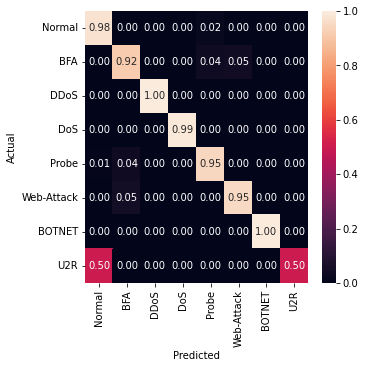

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(80, 100, 80), activation='relu', 
                    batch_size=100, learning_rate_init=0.001, max_iter=500, random_state=42)
mlp.fit(X_sm, y_sm.ravel())

y_pred = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test,y_pred)
mlp_f1 = f1_score(y_test,y_pred, average='macro')
print('Accuracy: ', mlp_acc)
print('F1: ', mlp_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

### Voting Classifier

Accuracy:  0.9858384948675448
F1:  0.8521969404357439


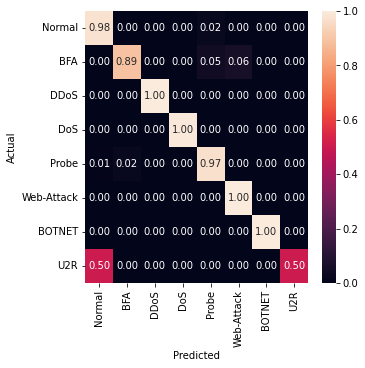

In [ ]:
tree = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=20, min_samples_split=2)
knn = KNeighborsClassifier(leaf_size=40, metric='euclidean', n_neighbors=4)
rf = RandomForestClassifier(random_state=42, criterion='gini', max_depth=50, max_features='sqrt', n_estimators=500)
mlp = MLPClassifier(hidden_layer_sizes=(80, 100, 80), activation='relu', 
                    batch_size=100, learning_rate_init=0.001, max_iter=500, random_state=42)


vc.fit(X_sm, y_sm)
y_pred = vc.predict(X_test)
vc_acc = accuracy_score(y_test,y_pred)
vc_f1 = f1_score(y_test,y_pred, average='macro')
print('Accuracy: ', vc_acc)
print('F1: ', vc_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

Accuracy:  0.9858094158015644
F1:  0.8564290605635487


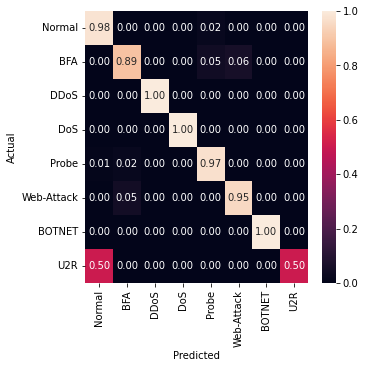

In [ ]:
vc = VotingClassifier(estimators=[('tree', tree), ('KNN', knn), ('RF', rf)], voting='soft')

vc.fit(X_sm, y_sm)
y_pred = vc.predict(X_test)
vc_acc = accuracy_score(y_test,y_pred)
vc_f1 = f1_score(y_test,y_pred, average='macro')
print('Accuracy: ', vc_acc)
print('F1: ', vc_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

### CNN

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
model = keras.Sequential()
model.add(keras.layers.Convolution1D(filters=128, kernel_size=3, activation='relu', input_shape=(48,1))) # 64
model.add(keras.layers.Convolution1D(filters=64, kernel_size=3, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu')) # 100
model.add(keras.layers.Dense(8, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['mae', 'accuracy'])

history = model.fit(X_sm, y_sm, epochs=25, #20
                  validation_data = (X_valid, y_valid), verbose=1)

Epoch 1/25
24383/24383 [==============================] - 101s 4ms/step - loss: 0.4011 - mae: 3.4062 - accuracy: 0.8535 - val_loss: 0.1798 - val_mae: 2.2521 - val_accuracy: 0.9563
Epoch 2/25
24383/24383 [==============================] - 100s 4ms/step - loss: 0.2021 - mae: 3.4062 - accuracy: 0.9252 - val_loss: 0.1046 - val_mae: 2.2521 - val_accuracy: 0.9729
Epoch 3/25
24383/24383 [==============================] - 100s 4ms/step - loss: 0.1705 - mae: 3.4062 - accuracy: 0.9354 - val_loss: 0.1144 - val_mae: 2.2521 - val_accuracy: 0.9670
Epoch 4/25
24383/24383 [==============================] - 104s 4ms/step - loss: 0.1555 - mae: 3.4062 - accuracy: 0.9410 - val_loss: 0.0996 - val_mae: 2.2521 - val_accuracy: 0.9740
Epoch 5/25
24383/24383 [==============================] - 105s 4ms/step - loss: 0.1456 - mae: 3.4062 - accuracy: 0.9448 - val_loss: 0.1162 - val_mae: 2.2521 - val_accuracy: 0.9633
Epoch 6/25
24383/24383 [==============================] - 105s 4ms/step - loss: 0.1371 - mae: 3.4062

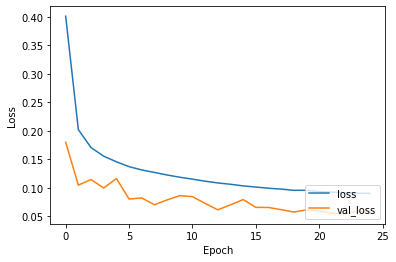

In [21]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

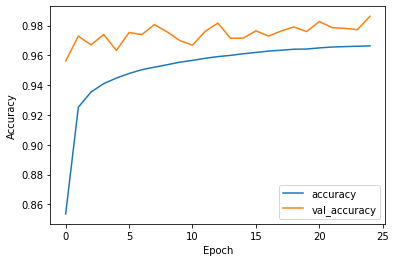

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

1075/1075 [==============================] - 1s 1ms/step
Accuracy:  0.9862746808572509
F1:  0.7955156960969263


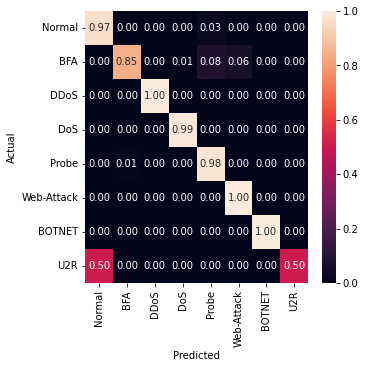

In [23]:
y_pred2 = model.predict(X_test)
# y_pred2 = np.rint(y_pred2)
y_pred = []
for i in range(len(y_pred2)):
  ind = np.where(y_pred2[i] == max(y_pred2[i]))[0].tolist()[0]
  y_pred.append(ind)

cnn_acc = accuracy_score(y_test,y_pred)
cnn_f1 = f1_score(y_test,y_pred, average='macro')
print('Accuracy: ', cnn_acc)
print('F1: ', cnn_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

### LSTM

In [7]:
def reshape_df(df):
  df_np = np.array(df)
  df_np = np.expand_dims(df_np, axis=1)
  return df_np

In [8]:
X_sm_lstm = reshape_df(X_sm)
X_test_lstm = reshape_df(X_test)
X_valid_lstm = reshape_df(X_valid)
X_sm_lstm.shape

(780232, 1, 48)

In [9]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(None, 48)))
model.add(keras.layers.LSTM(256, activation='relu', return_sequences=True)) # 512, 256
model.add(keras.layers.LSTM(128, activation='relu', return_sequences=True)) # 256, 128
model.add(keras.layers.LSTM(128, activation='relu', return_sequences=True)) # 256
#model.add(SeqSelfAttention(attention_activation='sigmoid', units=128))
model.add(keras.layers.LSTM(128, activation='relu', return_sequences=False)) # 128
model.add(keras.layers.Dense(100, activation='relu')) # 100
model.add(keras.layers.Dense(80, activation='relu')) # 80
model.add(keras.layers.Dense(8, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['mae', 'accuracy'])

In [10]:
history = model.fit(X_sm_lstm, y_sm, epochs=30, #30
                  validation_data = (X_valid_lstm, y_valid), verbose=1)

Epoch 1/30
24383/24383 [==============================] - 146s 6ms/step - loss: 0.5320 - mae: 3.4062 - accuracy: 0.8024 - val_loss: 0.2338 - val_mae: 2.2521 - val_accuracy: 0.9441
Epoch 2/30
24383/24383 [==============================] - 142s 6ms/step - loss: 0.2781 - mae: 3.4062 - accuracy: 0.9033 - val_loss: 0.1911 - val_mae: 2.2521 - val_accuracy: 0.9591
Epoch 3/30
24383/24383 [==============================] - 147s 6ms/step - loss: 0.2344 - mae: 3.4062 - accuracy: 0.9172 - val_loss: 0.1868 - val_mae: 2.2521 - val_accuracy: 0.9532
Epoch 4/30
24383/24383 [==============================] - 149s 6ms/step - loss: 0.2117 - mae: 3.4062 - accuracy: 0.9238 - val_loss: 0.1602 - val_mae: 2.2521 - val_accuracy: 0.9535
Epoch 5/30
24383/24383 [==============================] - 149s 6ms/step - loss: 0.1931 - mae: 3.4062 - accuracy: 0.9296 - val_loss: 0.1531 - val_mae: 2.2521 - val_accuracy: 0.9584
Epoch 6/30
24383/24383 [==============================] - 153s 6ms/step - loss: 0.1784 - mae: 3.4062

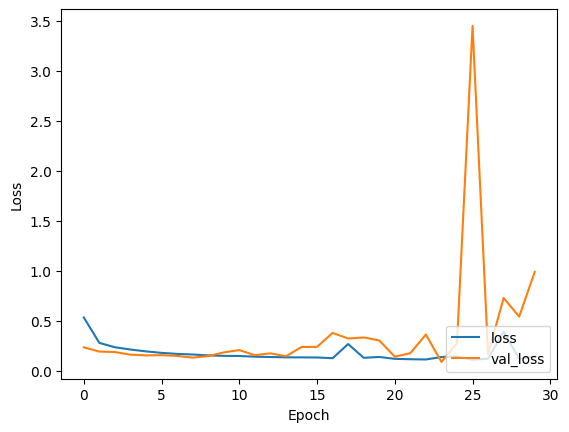

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

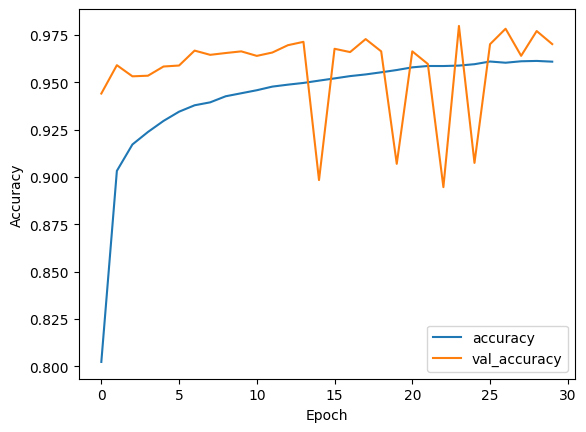

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

1075/1075 [==============================] - 2s 1ms/step
Accuracy:  0.9686527668731281
F1:  0.6876821464194778


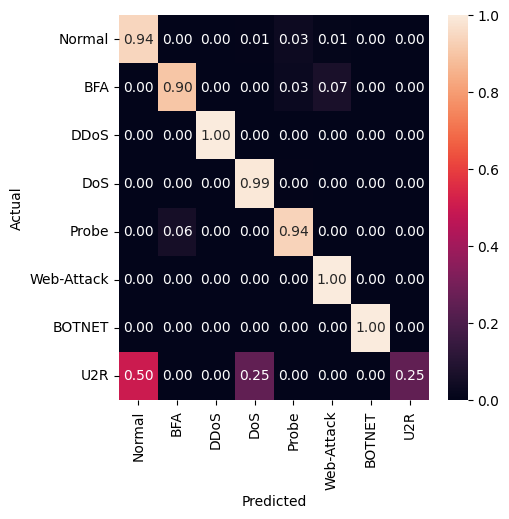

In [13]:
y_pred = model.predict(X_test_lstm)

for i in range(len(y_pred)):
  y_pred[i] = np.argmax(y_pred[i])

y_pred2 = []
for p in y_pred:
  y_pred2.append(int(p[0]))

lstm_acc = accuracy_score(y_test, y_pred2)
lstm_f1 = f1_score(y_test, y_pred2, average='macro')
print('Accuracy: ', lstm_acc)
print('F1: ', lstm_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred2))

### DatRet

Epoch 1/50
78023/78023 [==============================] - 99s 1ms/step - loss: 0.3935 - lr: 0.0010
Epoch 2/50
78023/78023 [==============================] - 101s 1ms/step - loss: 0.2304 - lr: 0.0010
Epoch 3/50
78023/78023 [==============================] - 100s 1ms/step - loss: 0.2000 - lr: 0.0010
Epoch 4/50
78023/78023 [==============================] - 104s 1ms/step - loss: 0.1917 - lr: 0.0010
Epoch 5/50
78023/78023 [==============================] - 97s 1ms/step - loss: 0.1824 - lr: 0.0010
Epoch 6/50
78023/78023 [==============================] - 99s 1ms/step - loss: 0.1842 - lr: 0.0010
Epoch 7/50
78023/78023 [==============================] - 100s 1ms/step - loss: 0.2070 - lr: 0.0010
Epoch 8/50
78023/78023 [==============================] - ETA: 0s - loss: 0.1871
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
78023/78023 [==============================] - 99s 1ms/step - loss: 0.1871 - lr: 0.0010
Epoch 9/50
78023/78023 [==============================] -

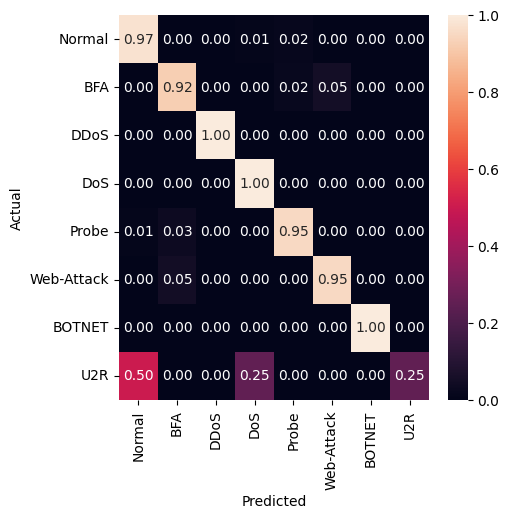

In [11]:
dr = DatRetClassifier()
dr.fit(X_sm, y_sm)

y_pred = dr.predict(X_test)
dr_acc = accuracy_score(y_test, y_pred)
dr_f1 = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', dr_acc)
print('F1: ', dr_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

Epoch 1/50
15604/15604 [==============================] - 88s 6ms/step - loss: 0.4196 - lr: 0.0010
Epoch 2/50
15604/15604 [==============================] - 87s 6ms/step - loss: 0.2607 - lr: 0.0010
Epoch 3/50
15604/15604 [==============================] - 88s 6ms/step - loss: 0.2237 - lr: 0.0010
Epoch 4/50
15604/15604 [==============================] - 88s 6ms/step - loss: 0.2065 - lr: 0.0010
Epoch 5/50
15604/15604 [==============================] - 91s 6ms/step - loss: 0.1909 - lr: 0.0010
Epoch 6/50
15604/15604 [==============================] - 92s 6ms/step - loss: 0.1797 - lr: 0.0010
Epoch 7/50
15604/15604 [==============================] - 92s 6ms/step - loss: 0.1827 - lr: 0.0010
Epoch 8/50
15604/15604 [==============================] - 92s 6ms/step - loss: 0.1726 - lr: 0.0010
Epoch 9/50
15604/15604 [==============================] - 92s 6ms/step - loss: 0.1624 - lr: 0.0010
Epoch 10/50
15604/15604 [==============================] - 91s 6ms/step - loss: 0.1550 - lr: 0.0010
Epoch 11/

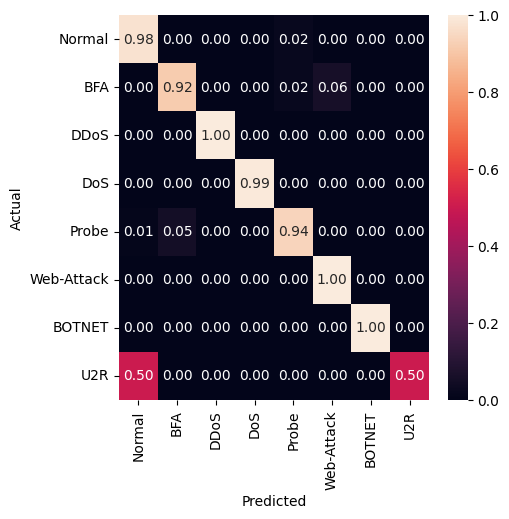

In [7]:
dr = DatRetClassifier(number_neurons=1000, batch_size=50)
dr.fit(X_sm, y_sm)

y_pred = dr.predict(X_test)
dr_acc = accuracy_score(y_test, y_pred)
dr_f1 = f1_score(y_test, y_pred, average='macro')
print('Accuracy: ', dr_acc)
print('F1: ', dr_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

### TabNet

In [26]:
X_sm_tabnet = X_sm.to_numpy()
y_sm_tabnet = y_sm.to_numpy()
X_valid_tabnet = X_valid.to_numpy()
y_valid_tabnet = y_valid.to_numpy()
X_test_tabnet = X_test.to_numpy()
y_test_tabnet = y_test.to_numpy()

In [27]:
tabnet = TabNetClassifier()
tabnet.fit(
  X_sm_tabnet, y_sm_tabnet,
  eval_set=[(X_valid_tabnet, y_valid_tabnet)]
)
y_pred = tabnet.predict(X_test_tabnet)

tabnet_acc = accuracy_score(y_test_tabnet,y_pred)
tabnet_f1 = f1_score(y_test_tabnet,y_pred, average='macro')
print('Accuracy: ', tabnet_acc)
print('F1: ', tabnet_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

NameError: name 'TabNetClassifier' is not defined

In [31]:
!pip install --upgrade git+https://github.com/tusharsarkar3/XBNet.git

  Cloning https://github.com/tusharsarkar3/XBNet.git to c:\users\dddl\appdata\local\temp\pip-req-build-6qmuxup_


  ERROR: Error [WinError 2] Не удается найти указанный файл while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?

[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### TabPFN

In [14]:
tab = TabPFNClassifier(device='cpu', N_ensemble_configurations=32)

tab.fit(X_sm, y_sm)
y_pred, p_eval = classifier.predict(X_test, return_winning_probability=True)

tab_acc = accuracy_score(y_test,y_pred)
tab_f1 = f1_score(y_test,y_pred, average='macro')
print('Accuracy: ', tab_acc)
print('F1: ', tab_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

ModuleNotFoundError: No module named 'tabpfn'

### CNN-LSTM

In [13]:
cnn = keras.Sequential()
cnn.add(keras.layers.Convolution1D(filters=64, kernel_size=3, activation='relu', input_shape=(48,1))) ## 128
cnn.add(keras.layers.Convolution1D(filters=64, kernel_size=3, activation='relu'))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.MaxPooling1D(pool_size=2))
# cnn.add(keras.layers.Flatten())
# cnn.add(keras.layers.Dense(128, activation='relu')) # 100
# cnn.add(keras.layers.Dense(8, activation='softmax'))
# cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['mae', 'accuracy'])

model = keras.Sequential()
# model.add(keras.layers.TimeDistributed(cnn))
model.add(cnn)
# model.add(keras.layers.Input(shape=(None, 48)))
model.add(keras.layers.LSTM(512, activation='relu', return_sequences=True))
#model.add(keras.layers.LSTM(256, activation='relu', return_sequences=True))
model.add(keras.layers.LSTM(256, activation='relu', return_sequences=True))
model.add(keras.layers.LSTM(128, activation='relu', return_sequences=False))
model.add(keras.layers.Dense(100, activation='relu')) # 100
model.add(keras.layers.Dense(80, activation='relu')) # 80
model.add(keras.layers.Dense(8, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['mae', 'accuracy'])

history = model.fit(X_sm, y_sm, epochs=5,
                  validation_data = (X_valid, y_valid), verbose=1)

Epoch 1/5
24383/24383 [==============================] - 3721s 152ms/step - loss: 2.0798 - mae: 3.4062 - accuracy: 0.1245 - val_loss: 2.0825 - val_mae: 2.2521 - val_accuracy: 6.1066e-04
Epoch 2/5
24383/24383 [==============================] - 3744s 154ms/step - loss: 2.0796 - mae: 3.4062 - accuracy: 0.1252 - val_loss: 2.0776 - val_mae: 2.2521 - val_accuracy: 0.2834
Epoch 3/5
24383/24383 [==============================] - 3815s 156ms/step - loss: 2.0795 - mae: 3.4062 - accuracy: 0.1253 - val_loss: 2.0823 - val_mae: 2.2521 - val_accuracy: 4.3619e-04
Epoch 4/5
24383/24383 [==============================] - 3813s 156ms/step - loss: 2.0796 - mae: 3.4062 - accuracy: 0.1258 - val_loss: 2.0764 - val_mae: 2.2521 - val_accuracy: 0.2834
Epoch 5/5
24383/24383 [==============================] - 3811s 156ms/step - loss: 2.0796 - mae: 3.4062 - accuracy: 0.1252 - val_loss: 2.0744 - val_mae: 2.2521 - val_accuracy: 0.0039


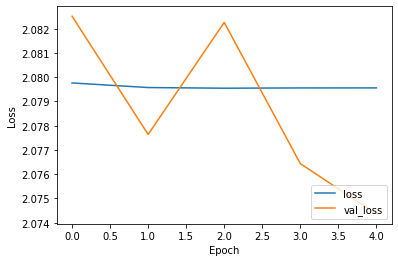

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

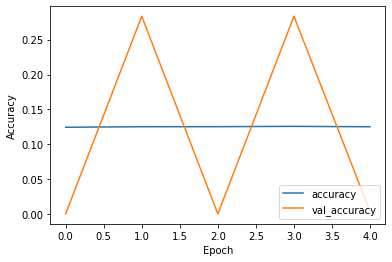

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [16]:
y_pred2 = model.predict(X_test)
## y_pred2 = np.rint(y_pred2)
# y_pred = []
# for i in range(len(y_pred2)):
#   ind = np.where(y_pred2[i] == max(y_pred2[i]))[0].tolist()[0]
#   y_pred.append(ind)

l_cnn_acc = accuracy_score(y_test,y_pred2)
l_cnn_f1 = f1_score(y_test,y_pred2, average='macro')
print('Accuracy: ', l_cnn_acc)
print('F1: ', l_cnn_f1)
plot_confusion_matrix(confusion_matrix(y_test, y_pred2))

1075/1075 [==============================] - 51s 47ms/step


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

## Результаты

In [ ]:
from tabulate import tabulate

col_names = ['Model', 'Accuracy', 'F1-score']
data = [['Random Forest', rf_acc, rf_f1],
        ['K-neighbors', knn_acc, knn_f1],
        ['Logistic Regression', lr_acc, lr_f1],
        ['Decision Tree', tree_acc, tree_f1],
        ['MLP', mlp_acc, mlp_f1],
        ['CNN', cnn_acc, cnn_f1],
        ['LSTM', lstm_acc, lstm_f1]]

print(tabulate(data, headers=col_names, tablefmt='fancy_grid'))

╒═════════════════════╤════════════╤════════════╕
│ Model               │   Accuracy │   F1-score │
╞═════════════════════╪════════════╪════════════╡
│ Random Forest       │   0.985431 │  0.855125  │
├─────────────────────┼────────────┼────────────┤
│ K-neighbors         │   0.98357  │  0.825721  │
├─────────────────────┼────────────┼────────────┤
│ Logistic Regression │   0.815261 │  0.425973  │
├─────────────────────┼────────────┼────────────┤
│ Decision Tree       │   0.98453  │  0.860703  │
├─────────────────────┼────────────┼────────────┤
│ MLP                 │   0.954026 │  0.655586  │
├─────────────────────┼────────────┼────────────┤
│ CNN                 │   0.971154 │  0.715761  │
├─────────────────────┼────────────┼────────────┤
│ LSTM                │   0.199163 │  0.0415212 │
╘═════════════════════╧════════════╧════════════╛
